## Goal


The goal is to perform [funnel analysis](https://en.wikipedia.org/wiki/Funnel_analysis) for an e-commerce website.

Typically, websites have a clear path to conversion: for instance, you land on the home page, then you search, select a product and buy it. At each of these steps, some users will drop off and leave the site. The sequence of pages that leads to conversion is called ‘funnel’ .

Data Science can have a tremendous impact on funnel optimization.
Funnel analysis allows to understand where/when our users abandon the website. It gives crucial insights on user behavior and on ways to improve the user experience as well as it often allows to discover bugs.

## Challenge Description


You are looking at data from an e-commerce website. The site is very simple and has just 4 pages:



- The first page is the <b>home page</b>. When you come to the site for the first time, you can only land on the home page as a first page.

- From the home page, the user can perform a search and land on the <b>search page</b>.

- From the search page, if the user clicks on a product, she will get to the <b>payment page</b>, where she is asked to provide payment information in order to buy that product.

- If she does decide to buy, she ends up on the <b>confirmation page</b>


The company CEO isn’t very happy with the company sales and, especially, sales coming from new users. Therefore, she asked you to investigate whether there is something wrong in the conversion funnel or, in general, if you can create hypotheses on how conversion rate could be improved.

Specifically, she is interested in :
- A full picture of funnel conversion rate for both desktop and mobile


- Some insights on what the product team should focus on in order to improve conversion rate as well as anything you might discover that could help improve conversion rate.

## Load Dataset

In [108]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

import graphviz
from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from graphviz import Source


%matplotlib inline

In [34]:
allusers = pd.read_csv("./Funnel_Analysis/home_page_table.csv",index_col="user_id")
users_to_search = pd.read_csv("./Funnel_Analysis/search_page_table.csv",index_col="user_id")
users_to_pay = pd.read_csv("./Funnel_Analysis/payment_page_table.csv",index_col="user_id")
users_to_confirm = pd.read_csv("./Funnel_Analysis/payment_confirmation_table.csv",index_col="user_id")


In [44]:
allusers.loc[users_to_search.index,'page'] = users_to_search.page
allusers.loc[users_to_pay.index,"page"] = users_to_pay.page
allusers.loc[users_to_confirm.index,"page"] = users_to_confirm.page

In [45]:
# give it a better, more clear name
allusers.rename(columns={'page':'final_page'},inplace=True)

In [49]:
# change string to ordered-categorical feature
pages = ["home_page","search_page","payment_page","payment_confirmation_page"]
page_type = CategoricalDtype(categories = pages, ordered = True)
allusers["final_page"] = allusers.final_page.astype(page_type)

In [51]:
user_infos = pd.read_csv("./Funnel_Analysis/user_table.csv",index_col="user_id")
user_infos.loc[:,"date"] = pd.to_datetime(user_infos.date)

In [53]:
allusers = allusers.join(user_infos)
allusers.head()

,final_page,date,device,sex
user_id,,,,
313593,home_page,2015-02-26,Desktop,Female
468315,home_page,2015-02-21,Desktop,Male
264005,home_page,2015-03-25,Desktop,Female
290784,home_page,2015-03-14,Desktop,Male
639104,search_page,2015-01-03,Desktop,Female


## Question 1
A full picture of funnel conversion rate for both desktop and mobile

In [75]:
allusers.groupby('device').final_page.value_counts()

device                            
Desktop  home_page                    30100
         search_page                  27090
         payment_page                  2860
         payment_confirmation_page      150
Mobile   home_page                    15100
         search_page                  12080
         payment_page                  2718
         payment_confirmation_page      302
Name: final_page, dtype: int64

In [72]:
cr = pd.concat([stage_counts,convert_from],axis=1,keys=["n_drop","n_convert"])

In [73]:
cr

,n_drop,n_convert
home_page,45200,45200
search_page,39170,6030
payment_page,5578,452
payment_confirmation_page,452,0


In [64]:
def conversion_rates(df):
    stage_counts = df.final_page.value_counts()
    #users converts from current page
    convert_from = stage_counts.copy()
    
    total = df.shape[0]
    for page in stage_counts.index:
        n_left = stage_counts.loc[page]# how many users just stop at current page
        n_convert = total - n_left
        convert_from[page] = n_convert
        total = n_convert

    cr = pd.concat([stage_counts,convert_from],axis=1,keys=["n_drop","n_convert"])
    cr["convert_rates"] = cr.n_convert.astype(np.float)/(cr.n_drop + cr.n_convert)
    cr['drop_rates'] = 1 - cr.convert_rates

    return cr

In [65]:
allusers.groupby('device').apply(conversion_rates)

n_drop  n_convert  convert_rates  \
device                                                                
Desktop home_page                   30100      30100       0.500000   
        search_page                 27090       3010       0.100000   
        payment_page                 2860        150       0.049834   
        payment_confirmation_page     150          0       0.000000   
Mobile  home_page                   15100      15100       0.500000   
        search_page                 12080       3020       0.200000   
        payment_page                 2718        302       0.100000   
        payment_confirmation_page     302          0       0.000000   

                                   drop_rates  
device                                         
Desktop home_page                    0.500000  
        search_page                  0.900000  
        payment_page                 0.950166  
        payment_confirmation_page    1.000000  
Mobile  home_page                    0.500000  
        search_page                  0.800000  
        payment_page                 0.900000  
        payment_confirmation_page    1.000000

In [76]:
allusers.groupby('device')['final_page'].apply(lambda s: s.value_counts(normalize=True)).unstack()


,home_page,search_page,payment_page,payment_confirmation_page
device,,,,
Desktop,0.5,0.45,0.047508,0.002492
Mobile,0.5,0.40,0.090000,0.010000


## Answer question 2
Some insights on what the product team should focus on in order to improve conversion rate as well as anything you might discover that could help improve conversion rate.

In [77]:
allusers.head()

,final_page,date,device,sex
user_id,,,,
313593,home_page,2015-02-26,Desktop,Female
468315,home_page,2015-02-21,Desktop,Male
264005,home_page,2015-03-25,Desktop,Female
290784,home_page,2015-03-14,Desktop,Male
639104,search_page,2015-01-03,Desktop,Female


In [78]:
x = allusers.copy()
x.device.value_counts()

Desktop    60200
Mobile     30200
Name: device, dtype: int64

In [81]:
x['from_mobile'] = (x.device == 'Mobile').astype(int)
del x['device']

In [82]:
x['is_male'] = (x.sex == 'Male').astype(int)
del x['sex']

In [83]:
x['converted'] = (x.final_page == 'payment_confirmation_page').astype(int)
del x['final_page']

In [85]:
x.converted.mean() # a highly imbalanced classification problem

0.005

## Impact of date

In [86]:
x.date.describe()

count                   90400
unique                    120
top       2015-02-08 00:00:00
freq                      877
first     2015-01-01 00:00:00
last      2015-04-30 00:00:00
Name: date, dtype: object

In [91]:
x['weekday'] = x.date.dt.day_name()
del x['date']

In [92]:
x.head()

,from_mobile,is_male,converted,weekday
user_id,,,,
313593,0,0,0,Thursday
468315,0,1,0,Saturday
264005,0,0,0,Wednesday
290784,0,1,0,Saturday
639104,0,0,0,Saturday


In [94]:
x.groupby('weekday')['converted'].agg(['count','mean']).sort_values(by='mean',ascending=False)


,count,mean
weekday,,
Monday,12955,0.005944
Saturday,12801,0.005468
Tuesday,12697,0.005434
Thursday,13444,0.004909
Sunday,12922,0.004798
Friday,12750,0.004235
Wednesday,12831,0.004209


## Impact of Sex

In [95]:
x.groupby('is_male')['converted'].agg(['count','mean']).sort_values(by = 'mean',ascending = False)


,count,mean
is_male,,
0,45075,0.005347
1,45325,0.004655


## Statistical Test

In [97]:
x = pd.get_dummies(x, prefix='',prefix_sep='')
x.head()

,from_mobile,is_male,converted,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
user_id,,,,,,,,,,
313593,0,0,0,0,0,0,0,1,0,0
468315,0,1,0,0,0,1,0,0,0,0
264005,0,0,0,0,0,0,0,0,0,1
290784,0,1,0,0,0,1,0,0,0,0
639104,0,0,0,0,0,1,0,0,0,0


In [98]:
y = x.converted
x = x.loc[:, x.columns !='converted']

In [100]:
scores, pvalues = chi2(x,y)

In [102]:
pd.DataFrame({'chi2_score':scores,'chi2_pvalue':pvalues},index = x.columns).sort_values(by='chi2_score',ascending=False)



,chi2_score,chi2_pvalue
from_mobile,151.758794,7.153913e-35
Monday,2.318821,1.278169e-01
Wednesday,1.615497,2.037208e-01
Friday,1.498670,2.208761e-01
is_male,1.082703,2.980938e-01
Saturday,0.564341,4.525166e-01
Tuesday,0.481501,4.877434e-01
Sunday,0.105964,7.447867e-01
Thursday,0.022253,8.814147e-01


In [109]:
dt = DecisionTreeClassifier(max_depth=3,min_samples_leaf=20,min_samples_split=20)
dt.fit(x,y)
export_graphviz(dt, out_file = 'tree_converted.dot', feature_names = x.columns,class_names = ['NotConvert','Converted'],
                proportion = True,leaves_parallel = True,filled = True)
with open('tree_converted.dot') as f:
    dot_graph = f.read()
s = Source.from_file('tree_converted.dot')
s.view()

'tree_converted.dot.pdf'

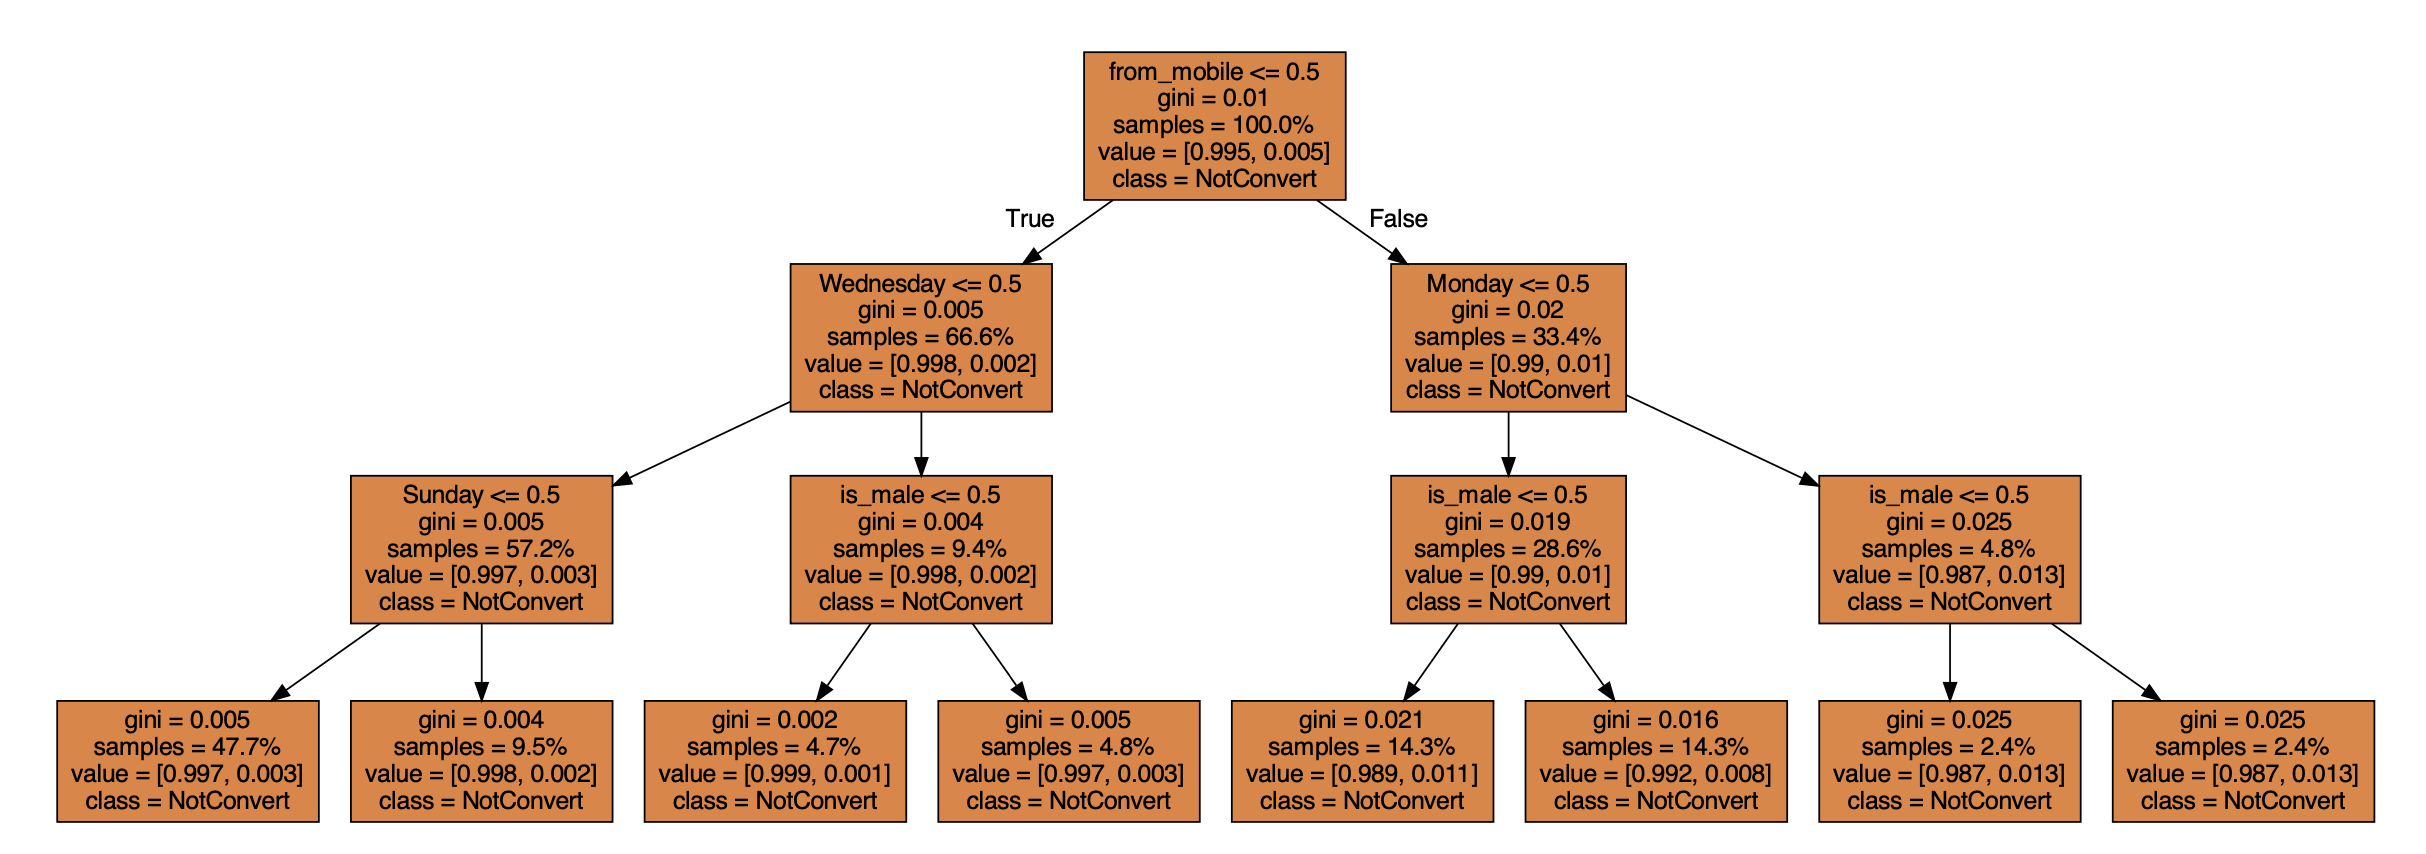